# Impacto do processo de LabelEncoder para variáveis Categóricas Ordinais

### Hipótese Proposta
Quando falamos de análise de dados, podemos dividir as variáveis em **numéricas** e **categóricas**, ou seja, aquelas que possuem valores numéricos e valores em texto, respectivamente. As categóricas podem ser **nominais**, ou seja, aquelas não mensuráveis, ou **ordinais**, aquelas que podem ser categorizadas sob uma determinada ordenação.
A ideia proposta busca verificar qual o impacto do processo de preprocessamento de dados LabelEncoder para variáveis ordinais.

A fim de explicar o fundamento por trás da proposta, considere o seguinte exemplo ilustrativo:
Dado um dataset com um atributo *faixa_etária*, com os possíveis valores (*criança*, *adolescente*, *jovem*, *adulto*, *idoso*). Busca-se predizer se tal indivíduo sofre de um doença que sabe-se que há um tendência de manifestação dela conforme o passar da idade (como por exemplo câncer).

### Funcionamento do processo de LabelEncoder
O processo de preprocessamento LabelEncoder transforma os valores de variáveis categóricas em valores numéricos de 0 a n-1, onde n é o numero de valores únicos encontrados para aquela variável. Porém, essa transformação é **feita sempre em ordem alfabética**, ou seja, organiza-se os valores em ordem alfabética e, seguindo essa ordem, associa os valores numéricos.

Dado o exemplo anterior, os possíveis valores para a variável *faixa_etária* são (*criança*, *adolescente*, *jovem*, *adulto*, *idoso*), ou seja, são 5 possíveis valores, logo eles receberão valores de 0 a 4. Dessa forma, tem-se as seguintes associações:
**adolescente = 0; adulto = 1; criança = 2; idoso = 3; jovem = 4**

### Mais sobre a Hipótese
Ainda sobre o fundamento da hipótese, uma criança possui características/comportamentos mais próximas de um adolescente, da mesma forma que os comportamentos de um adulto se aproximam mais às de um idoso ou de um jovem. Dessa forma, se considerarmos a lógica do algoritmo de KNN, no qual um ponto se assemelha mais aos pontos ao seu redor, presume-se que esse tipo de algoritmo se beneficiaria mais de um processo personalizado de label encoder, embora estima-se que essa tendência de semelhança possa também beneficiar os demais algoritmos.

A hipótese, então, propõe que a atribuição de valores seguindo a relação de ordenação entre os valores da variável pode implicar em melhoria da eficiência dos algoritmos de machine learning em relação a atribuição de valores de forma convencional, como é feito pelo LabelEncoder.

Ou seja, utilizando o exemplo acima, adotar as seguintes associações:
**criança = 0; adolescente = 1; jovem = 2; adulto = 3; idoso = 4**
resultaria em um modelo de machine learning com melhor precisão, pois permitiria ao modelo enxergar melhor essa tendência existente.

In [67]:
# ===== Importacao de Bibliotecas ===== #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

In [47]:
def cria_dicionario(lista):
    dict_lista = {}
    for i in range(len(lista)):
        dict_lista[lista[i]] = i
    
    return dict_lista

def especial_LabelEncoder(dicionarios, colunas):
    for n in range(len(previsores2)):
        for dicionario, col in zip(dicionarios, colunas):
            for key, val in dicionario.items():
                if previsores2[n][col] == key:
                    previsores2[n][col] = val
                    break

In [303]:
def create_model(opt_model, param):
    if opt_model == 'KNN':
        modelo = KNeighborsClassifier(n_neighbors=param, metric='minkowski', p=2)
    elif opt_model == 'Tree':
        modelo = DecisionTreeClassifier(criterion='entropy', random_state=param)
    elif opt_model == 'Forest':
        modelo = RandomForestClassifier(n_estimators=param, criterion='entropy', random_state=0)
    elif opt_model == 'SVM':
        modelo = SVC(kernel='rbf', C=param, random_state=1)
    elif opt_model == 'RNA':
        modelo = MLPClassifier(hidden_layer_sizes=param, tol=0.000001, solver='adam', learning_rate_init=0.001,
                              random_state=0)
    else:
        raise NameError ('Modelo escolhido nao esta na base de dados')
    
    return modelo

In [228]:
def create_test_model(model_name, model_param, i_train, i_test):
    modelo1 = create_model(model_name, model_param)
    modelo1.fit(previsores1[i_train], classe[i_train])
    previsoes1 = modelo1.predict(previsores1[i_test])
    score1 = accuracy_score(classe[i_test], previsoes1)
    
    modelo2 = create_model(model_name, model_param)
    modelo2.fit(previsores2[i_train], classe[i_train])
    previsoes2 = modelo2.predict(previsores2[i_test])
    score2 = accuracy_score(classe[i_test], previsoes2)
    
    return score1, score2

In [409]:
def avalia_modelo(n_seeds, model_name, model_param):
    global precisao1, precisao2
    
    print("{} ({})".format(model_name.title(), model_param))
    
    for seed in range(n_seeds):
        kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
        
        score_seed1 = []
        score_seed2 = []
        for i_train, i_test in kfold.split(previsores1, np.zeros(shape=(classe.shape[0], 1))):
            score1, score2 = create_test_model(model_name, model_param, i_train, i_test)
            
            score_seed1.append(score1)
            score_seed2.append(score2)
        
        score_seed1 = np.array(score_seed1)
        score_seed2 = np.array(score_seed2)
        
        precisao1.append(score_seed1.mean())
        precisao2.append(score_seed2.mean())
        
        if score_seed1.mean() > score_seed2.mean():
            print("seed {}: Score 1 - {:.5f} > {:.5f}".format(seed, score_seed1.mean(), score_seed2.mean()))
        elif score_seed1.mean() < score_seed2.mean():
            print("seed {}: Score 2 - {:.5f} < {:.5f}".format(seed, score_seed1.mean(), score_seed2.mean()))
        else:
            print("seed {}: Empate - {:.5f} = {:.5f}".format(seed, score_seed1.mean(), score_seed2.mean()))
    
    precisao1 = np.array(precisao1)
    precisao2 = np.array(precisao2)
    print("Media: \n 1: {:.5f}\n 2: {:.5f}".format(precisao1.mean(), precisao2.mean()))
    
    return precisao1.mean(), precisao2.mean()

In [215]:
def salva_resultados(medias, nome):
    global result_dataframe
    
    result_dataframe[nome] = medias
    result_dataframe.rename(index = {0: 'original', 1: 'proposto'}, inplace=True)
    

In [428]:
base = pd.read_csv("Credito.csv", sep=";", encoding="latin1")

In [429]:
# Analise da do dataset permite identificar 4 atributos categoricos ordinais
cheq_esp = list(base['CHEQUEESPECIAL'].unique())
bal_med_cred = list(base['BALANCO_MEDIO_CREDITO'].unique())
empregado = list(base['EMPREGADO'].unique())
emprego = list(base['EMPREGO'].unique())

print(cheq_esp)
print(bal_med_cred)
print(empregado)
print(emprego)

['<0', '0<=X<200', 'sem cheque', '>=200']
['nenhuma economia conhecida', '<100', '500<=X<1000', '>=1000', '100<=X<500']
['>=7', '1<=X<4', '4<=X<7', 'desempregado', '<1']
['especializado', 'não especializado', 'alta qualificação/autonomo/Gerente', 'unemp/unespecializado non res']


In [430]:
cheq_esp = ['<0', '0<=X<200', '>=200', 'sem cheque']
bal_med_cred = ['nenhuma economia conhecida', '<100', '100<=X<500', '500<=X<1000', '>=1000']
empregado = ['desempregado', '<1', '1<=X<4', '4<=X<7', '>=7']
emprego = ['unemp/unespecializado non res', 'não especializado', 'especializado', 'alta qualificação/autonomo/Gerente']

dict_cheq_esp = cria_dicionario(cheq_esp)
dict_bal_med_cred = cria_dicionario(bal_med_cred)
dict_empregado = cria_dicionario(empregado)
dict_emprego = cria_dicionario(emprego)

all_dict = [dict_cheq_esp, dict_bal_med_cred, dict_empregado, dict_emprego]
#all_dict = [dict_cheq_esp, dict_bal_med_cred, dict_empregado]

In [431]:
# Divisao dos atributos previsores e classe
previsores1 = base.iloc[:, 0:19].values # atributos previsores p/ utilizar LabelEncoder
previsores2 = base.iloc[:, 0:19].values # atributos previsores p/ utilizar processo proposto
classe = base.iloc[:, 19].values

In [432]:
# Preprocessamento LabelEncoder
encoder = LabelEncoder()

# Processo tradicional de LabelEncoder para todas as colunas com atributos categoricos
colunas = [0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18]
for c in colunas:
    previsores1[:, c] = encoder.fit_transform(previsores1[:, c])

# Processo tradicional de LabelEncoder somente para as colunas com atributos categoricos não ordinais
colunas = [2, 3, 8, 9, 11, 13, 14, 18]
for c in colunas:
    previsores2[:, c] = encoder.fit_transform(previsores1[:, c])

# Processo proposto de LabelEncoder para atributos ordinais
colunas = [0, 5, 6, 16]
especial_LabelEncoder(all_dict, colunas)


classe = encoder.fit_transform(classe)

In [433]:
# Preprocessamento Escalonamento
scaler = StandardScaler()
previsores1 = scaler.fit_transform(previsores1)
previsores2 = scaler.fit_transform(previsores2)

In [434]:
# Inicializar/Resetar o DataFrame que contem os resultados
#result_dataframe = pd.DataFrame()

In [447]:
# Avaliação
n_seed = 20

knn_params = [3, 5, 7, 9]
svm_params = [1.0, 1.5, 2.0, 2.5]
tree_params = [1, 2, 3]
forest_params = [12, 25, 50, 75]
rna_params = [(100), (50,50), (30,30,30)]

# Opções p/ model_name: 'KNN', 'Tree', 'Forest', 'SVM', 'RNA':
for parametro in rna_params:
    precisao1 = []
    precisao2 = []
    medias = avalia_modelo(n_seed, model_name='RNA', model_param=parametro)
    salva_resultados(medias, 'rna layer={}'.format(parametro))

result_dataframe

Rna (100)
seed 0: Score 2 - 0.74300 < 0.74800
seed 1: Score 2 - 0.73100 < 0.74000
seed 2: Score 1 - 0.74200 > 0.73200
seed 3: Score 2 - 0.72800 < 0.74400
seed 4: Score 2 - 0.72500 < 0.73600
seed 5: Score 2 - 0.73300 < 0.74600
seed 6: Score 2 - 0.73100 < 0.74900
seed 7: Score 2 - 0.73700 < 0.74200
seed 8: Score 1 - 0.74800 > 0.73600
seed 9: Score 1 - 0.74700 > 0.73000
seed 10: Score 2 - 0.73000 < 0.73700
seed 11: Score 2 - 0.72500 < 0.74000
seed 12: Score 2 - 0.73700 < 0.74000
seed 13: Score 2 - 0.73900 < 0.74300
seed 14: Score 2 - 0.73600 < 0.74300
seed 15: Score 2 - 0.72600 < 0.73800
seed 16: Score 2 - 0.73300 < 0.75800
seed 17: Score 2 - 0.73600 < 0.75400
seed 18: Score 2 - 0.73300 < 0.73500
seed 19: Score 2 - 0.73000 < 0.74700
Media: 
 1: 0.73450
 2: 0.74190
Rna ((50, 50))
seed 0: Score 2 - 0.72800 < 0.73100
seed 1: Score 2 - 0.70700 < 0.73300
seed 2: Score 2 - 0.72100 < 0.72300
seed 3: Score 2 - 0.70700 < 0.73200
seed 4: Score 2 - 0.71300 < 0.74600
seed 5: Score 2 - 0.71000 < 0.737

,knn n=3,knn n=5,knn n=7,knn n=9,svm c=1.0,svm c=1.5,svm c=2.0,svm c=2.5,tree seed=1,tree seed=2,tree seed=3,forest n=12,forest n=25,forest n=50,forest n=75,rna layer=100,"rna layer=(50, 50)","rna layer=(30, 30, 30)"
original,0.70535,0.7125,0.71205,0.72075,0.7420,0.74310,0.74355,0.74210,0.68060,0.68075,0.67935,0.74425,0.75145,0.75865,0.76060,0.7345,0.71575,0.7025
proposto,0.73325,0.7414,0.74110,0.74445,0.7675,0.76615,0.76470,0.76195,0.69095,0.69360,0.69085,0.74525,0.75980,0.76590,0.76835,0.7419,0.73575,0.7223


## Comparação do impacto da combinação dos diferentes atributos ordinais na precisão do algoritmo
A seguir são exibidos diferentes resultados obtidos utilizando os 4 atributos ordinais estudados e as possíveis combinações entre 3 desses atributos, a fim de identificar o impacto individual de cada um dos atributos quando é respeitada a relação de ordenação entre os valores desse atributo no processo de LabelEncoder.

In [474]:
# Resultado obtido realizando o ajuste nas ordens das variaveis
# utilizando (cheq_esp, bal_med_cred, empregado, emprego)
print("Resultado com os 4 Atributos: CHEQUE_ESPECIAL, BALANCO_MEDIO_CREDITO, EMPREGADO, EMPREGO")
result_df2

Resultado com os 4 Atributos: CHEQUE_ESPECIAL, BALANCO_MEDIO_CREDITO, EMPREGADO, EMPREGO


,knn n=3,knn n=5,knn n=7,knn n=9,svm c=1.0,svm c=1.5,svm c=2.0,svm c=2.5,tree seed=1,tree seed=2,tree seed=3,forest n=12,forest n=25,forest n=50,forest n=75,rna layer=100,"rna layer=50,50","rna layer=30,30,30"
original,0.70535,0.7125,0.71205,0.72075,0.7420,0.74310,0.74355,0.74210,0.68060,0.68075,0.67935,0.74425,0.75145,0.75865,0.76060,0.73450,0.71575,0.70250
proposto,0.73325,0.7414,0.74110,0.74445,0.7675,0.76615,0.76470,0.76195,0.69005,0.69545,0.69005,0.74880,0.75990,0.76680,0.77015,0.74505,0.73190,0.72075


In [467]:
# Resultado obtido realizando o ajuste nas ordens das variaveis
# utilizando (bal_med_cred, empregado, emprego)
print("Resultado com 3 Atributos: BALANCO_MEDIO_CREDITO, EMPREGADO, EMPREGO")
result_df3

,knn n=3,knn n=5,knn n=7,knn n=9,svm C=1.0,svm C=1.5,svm C=2.0,svm C=2.5,tree seed=1,tree seed=2,tree seed=3,forest n=12,forest n=25,forest n=50,forest n=75,rna layer=100,"rna layer=(50, 50)","rna layer=(30, 30, 30)"
original,0.70535,0.71250,0.71205,0.72075,0.74200,0.7431,0.74355,0.7421,0.68060,0.68075,0.67935,0.74425,0.75145,0.75865,0.7606,0.7345,0.71575,0.70250
proposto,0.71810,0.73195,0.73300,0.73510,0.75315,0.7557,0.75585,0.7565,0.69175,0.69415,0.69140,0.74690,0.75700,0.76460,0.7682,0.7364,0.73480,0.70255


In [468]:
# Resultado obtido realizando o ajuste nas ordens das variaveis
# utilizando (cheq_esp, empregado, emprego)
print("Resultado com 3 Atributos: CHEQUE_ESPECIAL, EMPREGADO, EMPREGO")
result_df4

,knn n=3,knn n=5,knn n=7,knn n=9,svm c=1.0,svm c=1.5,svm c=2.0,svm c=2.5,tree seed=1,tree seed=2,tree seed=3,forest n=12,forest n=25,forest n=50,forest n=75,rna layer=100,"rna layer=(50, 50)","rna layer=(30, 30, 30)"
original,0.70535,0.71250,0.71205,0.72075,0.74200,0.74310,0.74355,0.7421,0.68060,0.68075,0.67935,0.74425,0.75145,0.75865,0.76060,0.73450,0.71575,0.70250
proposto,0.72955,0.72895,0.73195,0.73840,0.76595,0.76585,0.76415,0.7619,0.68835,0.69065,0.68810,0.75005,0.75985,0.76515,0.76625,0.74535,0.73510,0.71695


In [475]:
# Resultado obtido realizando o ajuste nas ordens das variaveis
# utilizando (cheq_esp, bal_med_cred, emprego)
print("Resultado com 3 Atributos: CHEQUE_ESPECIAL, BALANCO_MEDIO_CREDITO, EMPREGO")
result_df5

Resultado com 3 Atributos: CHEQUE_ESPECIAL, BALANCO_MEDIO_CREDITO, EMPREGO


,knn n=3,knn n=5,knn n=7,knn n=9,svm c=1.0,svm c=1.5,svm c=2.0,svm c=2.5,tree seed=1,tree seed=2,tree seed=3,forest n=12,forest n=25,forest n=50,forest n=75,rna layer=100,"rna layer=(50, 50)","rna layer=(30, 30, 30)"
original,0.70535,0.7125,0.71205,0.72075,0.742,0.74310,0.74355,0.7421,0.68060,0.68075,0.67935,0.74425,0.75145,0.75865,0.7606,0.7345,0.71575,0.7025
proposto,0.71135,0.7187,0.72810,0.73075,0.753,0.75475,0.75350,0.7516,0.67955,0.68190,0.68085,0.74570,0.75685,0.76455,0.7659,0.7432,0.73735,0.7141


In [476]:
# Resultado obtido realizando o ajuste nas ordens das variaveis
# utilizando (cheq_esp, bal_med_cred, empregado)
print("Resultado com 3 Atributos: CHEQUE_ESPECIAL, BALANCO_MEDIO_CREDITO, EMPREGADO")
result_df6

Resultado com 3 Atributos: CHEQUE_ESPECIAL, BALANCO_MEDIO_CREDITO, EMPREGADO


,knn n=3,knn n=5,knn n=7,knn n=9,svm c=1.0,svm c=1.5,svm c=2.0,svm c=2.5,tree seed=1,tree seed=2,tree seed=3,forest n=12,forest n=25,forest n=50,forest n=75,rna layer=100,"rna layer=(50, 50)","rna layer=(30, 30, 30)"
original,0.70535,0.7125,0.71205,0.72075,0.7420,0.74310,0.74355,0.74210,0.68060,0.68075,0.67935,0.74425,0.75145,0.75865,0.76060,0.7345,0.71575,0.7025
proposto,0.73325,0.7414,0.74110,0.74445,0.7675,0.76615,0.76470,0.76195,0.69095,0.69360,0.69085,0.74525,0.75980,0.76590,0.76835,0.7419,0.73575,0.7223


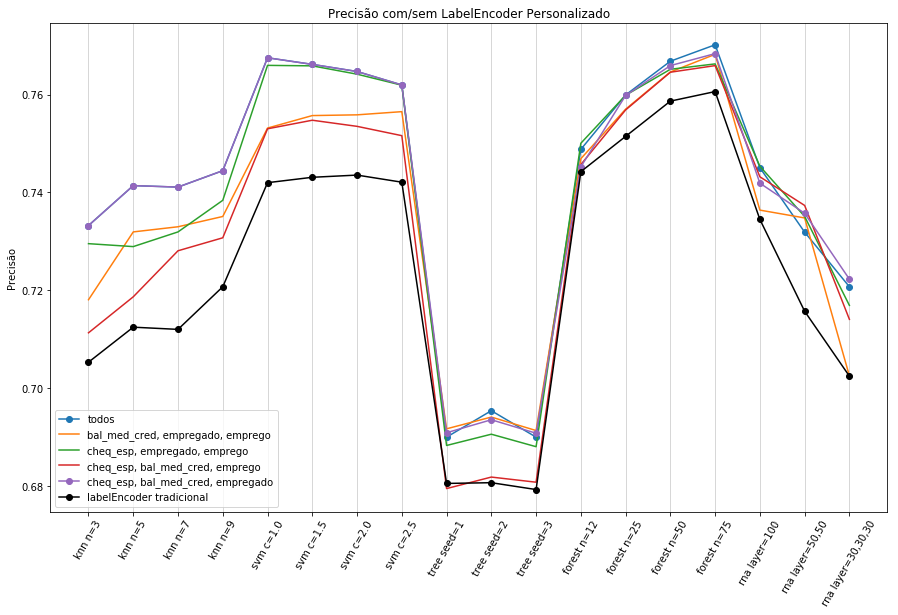

In [494]:
plt.figure(figsize=(15,9))
plt.plot(result_df2.columns, result_df2.iloc[1, :], 'o-', label='todos')
plt.plot(result_df2.columns, result_df3.iloc[1, :], label='bal_med_cred, empregado, emprego')
plt.plot(result_df2.columns, result_df4.iloc[1, :], label='cheq_esp, empregado, emprego')
plt.plot(result_df2.columns, result_df5.iloc[1, :], label='cheq_esp, bal_med_cred, emprego')
plt.plot(result_df2.columns, result_df6.iloc[1, :], 'o-', label='cheq_esp, bal_med_cred, empregado')
plt.plot(result_df2.columns, result_df2.iloc[0, :], 'o-', label='labelEncoder tradicional', color='black')
plt.legend()
plt.ylabel('Precisão')
plt.title('Precisão com/sem LabelEncoder Personalizado')
plt.xticks(rotation=60)
plt.grid(axis='x', linewidth='0.5')

### Análise Gráfica
Realizando o processo 'personalizado' de LabelEncoder nos 4 atributos selecionados **(cheque_especial, balanco_medio_credito, empregado, emprego)** e apenas nos 3 primeiros atributos selecionados **(cheque_especial, balanco_medio_credito, empregado)**, obteve-se resultados bem próximos, o que indica que a relação de ordenação entre os valores desse atributo **emprego** não contribui de forma significativa para melhoria dos algoritmos de machine learning.

Esse fato também é constatado fazendo a análise da tendência na relação do atributo e da classe utilizando o código abaixo, em que se verifica que uma alta qualificação não se reflete em uma tendência em ser um melhor pagador de crédito.


## Análise da Tendência na relação das variáveis ordinais e a classe
A análise feita a seguir mostra possíveis tendências na relacao entre os atributos ordinais e porcentagem de registros de bons/maus pagadores.

Essa análise pode auxiliar na definição da melhor ordem a ser seguida no processo de LabelEncoder personalizado e ao realizar a alteração, pode-se avaliar a resposta obtida utilizando o código acima a fim de confirmar que a mudança de fato gera uma melhora no resultado

In [491]:
def analise_atributo_pie(atributo):
    from math import ceil
    n_row = ceil(len(base[atributo].unique())/2)
    j = 1
    plt.figure(figsize=(10,9))
    for opt_value in base[atributo].unique():
        registros = base.loc[base[atributo] == opt_value]
        
        reg_bom = len(registros.loc[registros['CLASSE'] == 'bom'])
        reg_ruim = len(registros.loc[registros['CLASSE'] == 'ruim'])
        
        plt.subplot(n_row, 2, j)
        plt.pie([reg_bom, reg_ruim], labels=['Bom', 'Ruim'], startangle=90, counterclock=False,
                autopct=lambda p: '{:.1f}%'.format(p))
        plt.title('{}'.format(str(opt_value).title()))
        
        j += 1

def analise_atributo(atributo):
    ordem_orig = base[atributo].unique()
    ordem_prop = ordem_proposta(atributo)
    
    reg_tot = []
    reg_bom = []
    plt.figure(figsize=(11,9))
    plt.subplot(2,1,1)
    for opt_value in ordem_orig:
        registros = base.loc[base[atributo] == opt_value]
        reg_tot.append(len(registros))
        reg_bom.append(len(registros.loc[registros['CLASSE'] == 'bom']))
    for i in range(len(reg_bom)):
        reg_bom[i] = reg_bom[i]/reg_tot[i] * 100

    #plt.bar(ordem_orig, reg_tot)
    #plt.bar(ordem_orig, reg_bom, color='orange')
    plt.plot(ordem_orig, reg_bom, 'o-')
    plt.ylabel('% Bom Pagadores')
    plt.title('Ordem Original')
    
    
    # ORDEM PROPOSTA
    reg_tot = []
    reg_bom = []
    plt.subplot(2,1,2)
    for opt_value in ordem_prop:
        registros = base.loc[base[atributo] == opt_value]
        reg_tot.append(len(registros))
        reg_bom.append(len(registros.loc[registros['CLASSE'] == 'bom']))
    for i in range(len(reg_bom)):
        reg_bom[i] = reg_bom[i]/reg_tot[i] * 100

    #plt.bar(ordem_prop, reg_tot)
    #plt.bar(ordem_prop, reg_bom, color='orange')
    plt.plot(ordem_prop, reg_bom, color='orange', marker='o')
    plt.ylabel('% Bom Pagadores')
    plt.title('Ordem Proposta')

In [492]:
def ordem_proposta(atributo):
    if atributo == 'CHEQUEESPECIAL':
        return cheq_esp
    elif atributo == 'BALANCO_MEDIO_CREDITO':
        return bal_med_cred
    elif atributo == 'EMPREGADO':
        return empregado
    elif atributo == 'EMPREGO':
        return emprego

Ordem original: ['especializado' 'não especializado' 'alta qualificação/autonomo/Gerente'
 'unemp/unespecializado non res']
Ordem proposta: ['unemp/unespecializado non res', 'não especializado', 'especializado', 'alta qualificação/autonomo/Gerente']


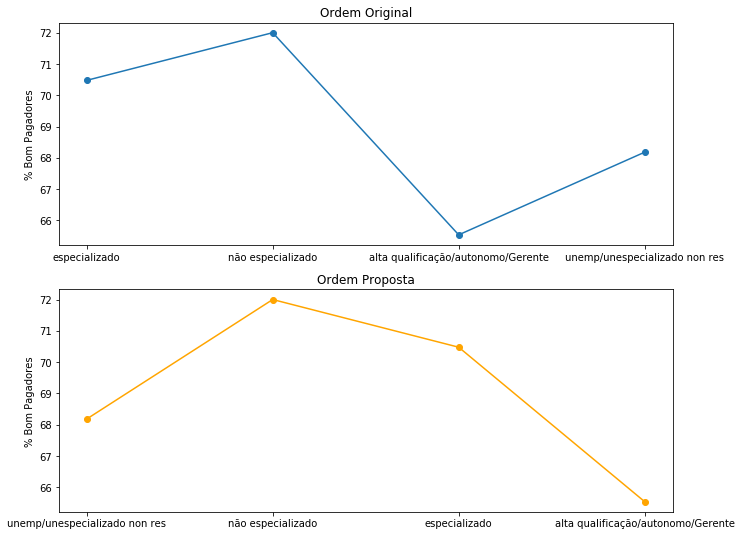

In [493]:
# atributos = 'CHEQUEESPECIAL', 'BALANCO_MEDIO_CREDITO', 'EMPREGADO', 'EMPREGO'
chosen_att = 'EMPREGO'
print("Ordem original: {}".format(base[chosen_att].unique()))
print("Ordem proposta: {}".format(ordem_proposta(chosen_att)))

analise_atributo(chosen_att)

## Conclusão
O processo de labelEncoder personalizado para variáveis categóricas ordinais, respeitando sua relação de ordenação, se mostra impactar de fato na precisão de algoritmos de machine learning.

Conforme esperado, o **impacto foi maior** nos algoritmos que utilizam cálculos de distância (como o caso do **KNN** e **SVM**) no seu processo de aprendizado.

Por fim, conforme verificado com o atributo '*emprego*', não basta simplesmente a variável ser do tipo ordinal, mas é **importante** que a **ordem de seus valores** apresente um **tendência** na relação com o atributo classe